In [1]:
import pandas as pd
import requests
import zipfile
import io
import os
import csv
import ctypes as ct
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import seaborn as sns

from bgs.load_bgs_amounts import load_bgs_amounts
from bgs.load_gilt_details import load_csv_blocks
from bgs.load_bgs_prices import load_prices
from bgs.gilt_analytics import gilt_yield

In [2]:
def clean_date(bgs_index):
    if re.match(r'^\d{2}\s\w{3}\s+\d{4}$', bgs_index):
        return pd.to_datetime(bgs_index, format="%d %b %Y", errors='coerce').to_period('M').to_timestamp('M')
    else:
        return pd.to_datetime(bgs_index).to_period('M').to_timestamp('M')

def clean_percentage(x):
    if x.strip() in ['Variable','Floating']:
        return x
    try:
        x = float(x)
    except (ValueError, TypeError):
        units, fractions = x.split(' ')
        num, denom = map(float, fractions.split('/'))
        x = float(units) + num / denom
        print(x)
    return x

In [3]:
tables = load_bgs_amounts("downloads/BGSAmounts.csv")

conv = tables['Conventionals']
conv.replace("Redeemed", "", inplace=True)
conv = conv.apply(pd.to_numeric, errors='coerce')
conv.fillna(0, inplace=True)
conv.index = pd.Index([clean_date(x) for x in list(conv.index)]).to_period('M').to_timestamp('M')

old = tables['Calculated indexed nominal Old-style']
old.replace("Redeemed", "", inplace=True)
old = old.apply(pd.to_numeric, errors='coerce')
old.fillna(0, inplace=True)
old.index = pd.Index([clean_date(x) for x in list(old.index)]).to_period('M').to_timestamp('M')

new = tables['Calculated indexed nominal New-style']
new.replace("Redeemed", "", inplace=True)
new = new.apply(pd.to_numeric, errors='coerce')
new.fillna(0, inplace=True)
new.index = pd.Index([clean_date(x) for x in list(new.index)]).to_period('M').to_timestamp('M')

new_no_idx = tables['Index-linked New-style']
new_no_idx.replace("Redeemed", "", inplace=True)
new_no_idx = new_no_idx.apply(pd.to_numeric, errors='coerce')
new_no_idx.fillna(0, inplace=True)
new_no_idx.index = pd.Index([clean_date(x) for x in list(new_no_idx.index)]).to_period('M').to_timestamp('M')


In [4]:
price_df=load_prices("downloads/BGSPrices.csv")
price_df.index = pd.to_datetime(price_df.index, format="%d %b %Y").to_period('M').to_timestamp('M')
for text in ['Amalgamated', 'Redeemed', 'redeemed']:
    price_df = price_df.replace(text, 0)
price_df = price_df.replace('missing', None)
price_df = price_df.ffill(axis=0)
price_df = price_df.fillna(0)

/tmp/ipykernel_18153/736416946.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.replace(text, 0)
/tmp/ipykernel_18153/736416946.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.ffill(axis=0)


In [5]:
details = load_csv_blocks("downloads/BGSDetails.csv")

details.keys()

dict_keys(['Conventionals', 'Index-Linked Old-style', 'Index-Linked New-style'])

In [6]:

conv_details = details['Conventionals']
conv_details['%'] = conv_details['%'].apply(clean_percentage)

new_details = details['Index-Linked New-style']
new_details['%'] = new_details['%'].apply(clean_percentage)

old_details = details['Index-Linked Old-style']
old_details['%'] = old_details['%'].apply(clean_percentage)


3.75


In [7]:
last = '2025-04-30'

In [8]:
linkers = new.loc[last, new.loc[last] !=0].reset_index()['index'].to_list()
linkers[0]

'55280'

In [9]:
last_price = price_df.loc[last, [int(x) for x in linkers]]
principal = new.loc[last, linkers]

In [10]:
principal.index = principal.index.astype(int)
principal.name = 'balance_outstanding'
last_price.name = 'price'

In [11]:
data_set_april = last_price.reset_index().merge(principal.reset_index(), on='index')
data_set_april.rename(columns={'index': 'Sequence'}, inplace=True)

In [12]:
#Average Price
(data_set_april['balance_outstanding']*data_set_april['price']).sum()/data_set_april['balance_outstanding'].sum()

np.float64(80.75752808115158)

In [13]:
data_set_april.head()

,Sequence,price,balance_outstanding
0,55280,99.822,20527.9
1,55300,103.049,28768.8
2,55310,99.967,25309.3
3,55320,99.130,25654.0
4,55340,97.042,15437.8


In [14]:
new_details['Sequence'] = new_details['Sequence'].astype(int)

In [15]:
len([x for x in new_details['Sequence'] if x in [int(y) for y in linkers]])

32

In [16]:
len(linkers)

32

In [17]:
new_details.columns

Index(['Sequence', 'Inst Code', 'Sedol', 'ISIN Code', '%', 'Stock', 'Suffix',
       'Special features', 'First year', 'Last year', 'Issue date',
       'First coupon payable on date', 'Earliest redemption date',
       'Latest redemption date', 'A (B, C ...) stock merged on date',
       'Actually redeemed', 'Frequency', 'Payment date 1', 'Payment date 2',
       'Payment date 3', 'Payment date 4', 'First coupon',
       'IL coupon rounding', 'IL redemption rounding', 'Indexing lag',
       'Base month', 'Base RPI', 'Number of calls', 'Call payment 1',
       'due on 1', 'Call payment 2', 'due on 2', 'Call payment 3', 'due on 3',
       'Call payment 4', 'due on 4', ''],
      dtype='object')

In [18]:
date_variables = ["Latest redemption date","Issue date","First coupon payable on date",]
static_variables = ['%', "Frequency","Sequence",'ISIN Code']+date_variables
data_set_april = data_set_april.merge(new_details[static_variables].set_index("Sequence"), on='Sequence', how='inner')
for date_var in date_variables:
    data_set_april[date_var] = data_set_april[date_var].apply(clean_date)
data_set_april.head()

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date
0,55280,99.822,20527.9,0.125,2,GB00BYY5F144,2026-03-31,2015-07-31,2015-09-30
1,55300,103.049,28768.8,1.250,2,GB00B128DH60,2027-11-30,2006-04-30,2006-11-30
2,55310,99.967,25309.3,0.125,2,GB00BZ1NTB69,2028-08-31,2018-06-30,2019-02-28
3,55320,99.130,25654.0,0.125,2,GB00B3Y1JG82,2029-03-31,2011-11-30,2012-03-31
4,55340,97.042,15437.8,0.125,2,GB00BNNGP551,2031-08-31,2021-01-31,2021-08-31


In [19]:
(data_set_april['balance_outstanding']*data_set_april['%']).sum()/data_set_april['balance_outstanding'].sum()

np.float64(0.5083613626563174)

<Axes: ylabel='Frequency'>

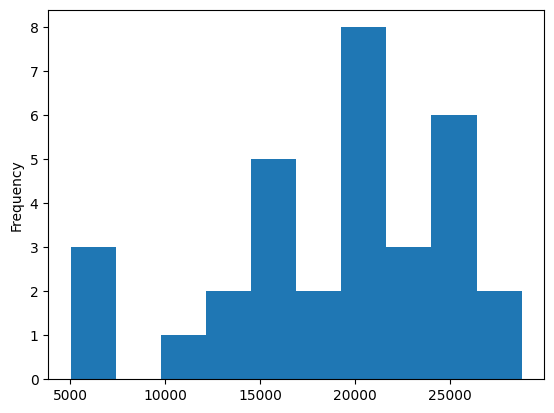

In [20]:
data_set_april['balance_outstanding'].plot(kind='hist')

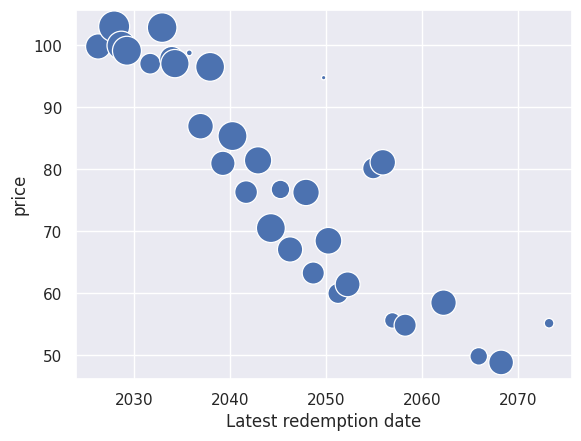

In [21]:
sns.set_theme(style="darkgrid")

# use the scatterplot function to build the bubble map
ax = sns.scatterplot(
    data=data_set_april,
    x="Latest redemption date",
    y="price",
    size="balance_outstanding",
    legend=False,
    sizes=(10, 500)
)

# show the graph
plt.show()

In [22]:
august = "2022-08-31"
september = "2022-09-30"
december = "2022-12-31"

In [23]:
liz_linkers  = new.loc[august, new.loc[august] !=0].reset_index()['index'].to_list()

In [24]:
august_price = price_df.loc[august, [int(x) for x in liz_linkers]]
september_price = price_df.loc[september, [int(x) for x in liz_linkers]]
december_price = price_df.loc[december, [int(x) for x in liz_linkers]]

In [25]:
last_price.name='Apr-2025'
august_price.name='Aug-2022'
september_price.name='Sep-2022'
december_price.name='Dec-2022'

In [26]:
history = pd.concat([last_price, august_price, september_price, december_price], axis=1)

In [27]:
history = history.replace(0.000, np.nan)
history

,Apr-2025,Aug-2022,Sep-2022,Dec-2022
55280,99.822,108.205,101.036,100.937
55300,103.049,116.836,106.484,105.846
55310,99.967,111.371,100.421,100.252
55320,99.130,111.793,100.102,99.826
55340,97.042,115.234,101.326,100.660
55350,102.862,127.450,111.520,110.980
55360,97.882,NaN,NaN,NaN
55375,97.053,122.230,106.790,105.190
55380,98.790,NaN,NaN,NaN
55385,86.960,116.210,102.270,96.820


In [28]:
history = history.reset_index().rename(columns={'index':'Sequence'})
history = history.merge(new_details[['Sequence','Latest redemption date']], on='Sequence', how='left')

In [29]:
history['Latest redemption date'] = history['Latest redemption date'].apply(clean_date)
history.set_index('Latest redemption date', inplace=True)
history.drop(columns=['Sequence'], inplace=True)


<Axes: xlabel='Latest redemption date'>

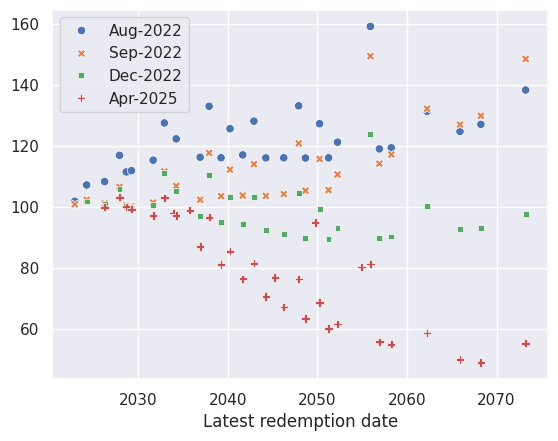

In [30]:
sns.scatterplot(data=history[['Aug-2022','Sep-2022','Dec-2022','Apr-2025']])

In [31]:
higher_prices = [55360,55380, 55465,55485, 55500]

In [32]:
data_set_april.loc[data_set_april['Sequence'].isin(higher_prices)]

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date
6,55360,97.882,19168.4,0.750,2,GB00BMF9LJ15,2033-11-30,2023-06-30,2023-11-30
8,55380,98.790,5395.0,1.125,2,GB00BT7HZZ68,2035-09-30,2025-01-31,2025-09-30
20,55465,94.790,5026.1,1.875,2,GB00BT7J0134,2049-09-30,2025-03-31,2025-09-30
24,55485,80.170,15663.1,1.250,2,GB00BPSNBG80,2054-11-30,2024-03-31,2024-05-31
25,55500,81.140,20846.3,1.250,2,GB00B0CNHZ09,2055-11-30,2005-09-30,2006-05-31


In [33]:
df_infl = pd.ExcelFile("downloads/GLC Inflation month end data_2016 to 2024.xlsx")

In [34]:
df_infl.sheet_names

['info',
 '1. fwds, short end',
 '2. fwd curve',
 '3. spot, short end',
 '4. spot curve']

In [35]:
df_spot = pd.read_excel(df_infl, sheet_name='4. spot curve', header=3, skiprows=[4]).set_index('years:')

In [36]:
df_spot.head()

,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,...,35.5,36.0,36.5,37.0,37.5,38.0,38.5,39.0,39.5,40.0
years:,,,,,,,,,,,,,,,,,,,,,
2016-01-31,2.093930,2.126727,2.157546,2.187497,2.217622,2.248480,2.280394,2.313505,2.347776,2.383026,...,3.241062,3.231737,3.222785,3.214251,3.206172,3.198583,3.191511,3.184981,3.179011,3.173616
2016-02-29,1.782252,1.828895,1.869755,1.908187,1.946258,1.984937,2.024674,2.065621,2.107721,2.150780,...,3.175429,3.165960,3.156853,3.148159,3.139928,3.132201,3.125014,3.118399,3.112382,3.106984
2016-03-31,2.284439,2.289024,2.291967,2.297093,2.305987,2.319153,2.336621,2.358143,2.383257,2.411380,...,3.197401,3.187551,3.178133,3.169200,3.160797,3.152966,3.145741,3.139151,3.133222,3.127974
2016-04-30,2.379762,2.361771,2.348882,2.342841,2.343795,2.351424,2.365191,2.384399,2.408202,2.435671,...,3.171228,3.160620,3.150474,3.140848,3.131791,3.123345,3.115547,3.108429,3.102016,3.096328
2016-05-31,2.271849,2.265991,2.265072,2.269025,2.277340,2.289643,2.305641,2.325025,2.347407,2.372360,...,3.057144,3.046329,3.036012,3.026247,3.017084,3.008564,3.000723,2.993589,2.987186,2.981532


In [37]:
df_spot.loc[df_spot.index=='2023-07-31'].to_dict(orient="list")

{2.5: [3.065036564635605],
 3: [3.216705586993055],
 3.5: [3.3176272570181586],
 4: [3.3834882862058184],
 4.5: [3.4254283087213846],
 5: [3.451495066511068],
 5.5: [3.4670942296715688],
 6: [3.4759703153409545],
 6.5: [3.480751591335479],
 7: [3.483260133223774],
 7.5: [3.4847186528323353],
 8: [3.4859160608060424],
 8.5: [3.4873234694269164],
 9: [3.4891710076764655],
 9.5: [3.491518392229231],
 10: [3.4942980117860296],
 10.5: [3.4973650673829146],
 11: [3.5005441134945072],
 11.5: [3.5036331347914182],
 12: [3.506418428049002],
 12.5: [3.508703480249646],
 13: [3.5103143319967955],
 13.5: [3.5111085383379153],
 14: [3.5109820230306337],
 14.5: [3.5098615357646836],
 15: [3.507706025049218],
 15.5: [3.504510470021813],
 16: [3.5002993810213385],
 16.5: [3.4951207603668317],
 17: [3.489040119279295],
 17.5: [3.482135034037176],
 18: [3.474492208841023],
 18.5: [3.4662027889715645],
 19: [3.4573588894841794],
 19.5: [3.448051265163678],
 20: [3.438368421723607],
 20.5: [3.428395336241

In [38]:
df_short_spot = pd.read_excel(df_infl, sheet_name='3. spot, short end', header=3, skiprows=[4])

In [39]:
df_short_spot.head()

,years:,2.083333,2.166667,2.25,2.333333,2.416667,2.5,2.583333,2.666667,2.75,...,4.25,4.333333,4.416667,4.5,4.583333,4.666667,4.75,4.833333,4.916667,5.0
0,2016-01-31,2.066599,2.071858,2.077271,2.082782,2.088346,2.093930,2.099506,2.105053,2.110557,...,2.202496,2.207521,2.212562,2.217622,2.222703,2.227807,2.232935,2.238089,2.243270,2.248480
1,2016-02-29,1.737597,1.746932,1.756077,1.765017,1.773744,1.782252,1.790541,1.798614,1.806477,...,1.927191,1.933534,1.939889,1.946258,1.952646,1.959054,1.965485,1.971942,1.978425,1.984937
2,2016-03-31,2.277160,2.278889,2.280487,2.281946,2.283263,2.284439,2.285479,2.286391,2.287187,...,2.301023,2.302560,2.304215,2.305987,2.307880,2.309893,2.312026,2.314281,2.316657,2.319153
3,2016-04-30,2.397601,2.393805,2.390134,2.386576,2.383120,2.379762,2.376499,2.373335,2.370273,...,2.342458,2.342715,2.343161,2.343795,2.344616,2.345619,2.346805,2.348169,2.349709,2.351424
4,2016-05-31,2.281144,2.278854,2.276808,2.274973,2.273326,2.271849,2.270528,2.269351,2.268312,...,2.272664,2.274109,2.275669,2.277340,2.279122,2.281013,2.283012,2.285118,2.287329,2.289643


In [40]:
df_short_spot.loc[df_short_spot['years:']=='2023-07-31']

,years:,2.083333,2.166667,2.25,2.333333,2.416667,2.5,2.583333,2.666667,2.75,...,4.25,4.333333,4.416667,4.5,4.583333,4.666667,4.75,4.833333,4.916667,5.0
90,2023-07-31,NaN,NaN,NaN,NaN,3.033242,3.065037,3.094747,3.122521,3.148489,...,3.406872,3.413545,3.41972,3.425428,3.430702,3.43557,3.440059,3.444194,3.447998,3.451495


In [41]:
x=3
x*2//2 ==x

True

In [43]:
0.3788/0.0075*2

101.01333333333335